## Lectura de los archivos en ruta y construcción de estados, y generación de nuevas tablas

In [3]:
# se cargan las librerias

import re
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv


#carga las variables de entorno desde archivo .env en carpeta env_variables
%load_ext dotenv
%dotenv ./env_variables/.env


# funcion para cargar barra de progreso
def progress(percent=0, width=40):
    left = width * percent // 100
    right = width - left
    
    tags = "#" * left
    spaces = " " * right
    percents = f"{percent:.0f}%"
    
    print("\r[", tags, spaces, "]", percents, sep="", end="", flush=True)


load_dotenv()

# se carga la ruta de los datos
ruta = os.environ['ruta_datos']

# espefición de columnas a rescatar del dataset 
tag1 = 'RIO_20482_CBI_15361_101.SD_CDV_16_NP'
tag2 = 'RIO_20488_CBI_15362_101.SD_CDV_15_BA'

# se identifican las columnas {tiempo, #tag1, #tag2, #frame}
cdv1 = ['frame.number','_ws.col.Time', tag1, tag2]

# crea un dataFrame que tendrá las columnas indicadas; identificación del tren, tiempos y a qué sensor corresponde
result = pd.DataFrame(columns=['numberTrain','timeArriving', 'timeDeparture', 'timeOcuppancy', 'tagCdv'])

# lectura de los archivo .csv desde la ruta y filtra solo estos tipo de archivos .csv
listaFiles= os.listdir(ruta)
for i, file in enumerate(listaFiles):
    is_csv = re.search(r'.csv',file, re.IGNORECASE)
    if (is_csv != None):
        df = pd.read_csv(ruta + '/' +  file)

        datos =[]
        
        #filtra las columnas, lo único que se diferencia es que si tiene el tag1 o tag2
        list_columns = [col for col in df.columns if col in cdv1 ]

        # selecciona las columnas del dataFrame
        df_cdv = df[list_columns]

        # muestra los nombres de las columnas, solo por testing.
        #print(f'cdv: {df_cdv.columns} , file:{file}')
        porcentaje_bar = (i/len(listaFiles))*100
        progress(round(porcentaje_bar))

        # Elimina los valores Nan por razones analizadas anteriormente
        df_cdv = df_cdv.dropna().reset_index(drop=True)
        
        # renombra los nombres de las columnas
        df_cdv = df_cdv.rename(columns={"frame.number": "idx", "_ws.col.Time": "date-time", list_columns[2]:"data"})
        
        #convierte el tipo de dato, desde objet to datatime
        df_cdv['date-time'] = pd.to_datetime(df_cdv['date-time'])
        
        
        #rescata solo el tiempo desde columna date-time
        df_cdv['tiempo'] = df_cdv['date-time'].apply( lambda x: x.time())

        #se filtra los datos entre 6 am to 11 pm
        df_cdv = df_cdv.set_index('date-time').between_time('06:00', '23:00')
        
        # Detecta si el dataFrame está vacio o no, debido a que archivos tienen diferentes ventanas de mediciones
        if(len(df_cdv) > 0):

            
            # detección de cambios de estado de bajo-alto, alto-bajo
            datos = df_cdv

            
            # se convierte la señal
            datos['data'] = abs(datos.data - 1)

            #se inicia primer valor.
            flags = [int(datos.data.iloc[0])]

            # es solo para testing
            #print(f'flags[0]:{flags}')

            # se verifica los estados de máquina
            for x in range(1,len(datos)):
                if (datos.data.iloc[x] == 1 and datos.data.iloc[x-1] == 0):
                    flags.append(1)
                elif(datos.data.iloc[x] == 0 and datos.data.iloc[x-1] == 1):
                    flags.append(2)
                elif(datos.data.iloc[x] == 0 and datos.data.iloc[x-1] == 0):
                    flags.append(0)
                else:
                    flags.append(3)

            # se agrega una columna con los estados = flags
            df_cdv['flags'] = flags
            
            
            # se crean los arreglos de tiempo
            timeArriving = []
            timeDeparture = []
            numberTrain = []
            timeOcuppancy = []

            # se cargan a datos el dataFrame principal
            datos = df_cdv

            # se identifican los cambios de estado 1 y 2 que corresponden a cambios de estado.
            for x in range(len(datos)):
                if(datos['flags'].iloc[x] == 1):
                    timeArriving.append(datos.index[x])
                    numberTrain.append(x)
                elif(datos['flags'].iloc[x] == 2):
                    timeDeparture.append(datos.index[x])

            #diferencia entre listas de datos porque a veces no termina con exactitud en el estado inicial
            diferencia = len(timeDeparture) - len(timeArriving)

            # Elimina el último dato
            if(diferencia < 0):
                timeArriving.pop()
                numberTrain.pop()

            #Calculo de tiempo de ocupacióon
            for y in range(len(timeDeparture)):
                deltaTime = timeDeparture[y] - timeArriving[y]
                timeOcuppancy.append(deltaTime)
            
            # muestra el tamaño de los datos y la diferencia que hubo, solo para testing.
            #print(f'{len(timeArriving)}, {len(timeDeparture)}, {len(timeOcuppancy)}, {len(numberTrain)}, {diferencia}')

            # identifica si el archivo pertenece a tag1 o tag2
            is_cdv1 = tag1 in list_columns
            is_cdv2 = tag2 in list_columns
            
            #Genera columna de tagcdv según el archivo leido
            if (is_cdv1):
                tagCdv = ['cdv1'] * len(timeArriving)
            elif (is_cdv2):
                tagCdv = ['cdv2'] * len(timeArriving)
            else:
                tagCdv = ['None'] * len(timeArriving)

            
            # crea diccionario con las listas creadas para luego crear un dataFrame
            trainDict = {   
                'numberTrain': numberTrain,'timeArriving': timeArriving,    
                'timeDeparture':timeDeparture, 'timeOcuppancy':timeOcuppancy,   
                'tagCdv':tagCdv
                }
            timeDataFrame = pd.DataFrame(trainDict)
            
            #calculo de los minutos
            timeDataFrame['minutes'] = timeDataFrame['timeOcuppancy'] / pd.Timedelta(minutes=1)

            # Une los dataFrame
            frames = [result, timeDataFrame]
            result = pd.concat(frames)

[####################################### ]99%

In [4]:
# verificamos que se hayan cargado los datos y columnas.
result.head(5)

,numberTrain,timeArriving,timeDeparture,timeOcuppancy,tagCdv,minutes
0,773,2024-01-02 20:58:21.174256,2024-01-02 20:58:55.581749,0 days 00:00:34.407493,cdv1,0.573458
1,2180,2024-01-02 21:03:02.635136,2024-01-02 21:03:37.042550,0 days 00:00:34.407414,cdv1,0.573457
2,3624,2024-01-02 21:07:51.497472,2024-01-02 21:08:26.104974,0 days 00:00:34.607502,cdv1,0.576792
3,4997,2024-01-02 21:12:26.156647,2024-01-02 21:13:00.564016,0 days 00:00:34.407369,cdv1,0.573456
4,6426,2024-01-02 21:17:12.018821,2024-01-02 21:17:46.426515,0 days 00:00:34.407694,cdv1,0.573462


In [5]:
# dar una mirada a los resultados
result.describe()

,timeArriving,timeDeparture,timeOcuppancy,minutes
count,2961,2961,2961,2961.000000
mean,2024-01-05 11:09:52.816368128,2024-01-05 11:10:26.440934144,0 days 00:00:33.624565782,0.560409
min,2024-01-02 20:55:46.484170,2024-01-02 20:56:01.888661,0 days 00:00:01.397398,0.023290
25%,2024-01-04 07:27:14.150921984,2024-01-04 07:27:47.557021952,0 days 00:00:31.011482,0.516858
50%,2024-01-05 09:17:25.639662080,2024-01-05 09:17:56.849850112,0 days 00:00:33.202134,0.553369
75%,2024-01-06 14:42:49.391898112,2024-01-06 14:43:20.598583040,0 days 00:00:34.607535,0.576792
max,2024-01-08 10:24:01.331483,2024-01-08 10:24:35.739858,0 days 00:01:06.218845,1.103647
std,NaN,NaN,0 days 00:00:04.078967392,0.067983


## Visualización de los datos para saber como se destribuye

In [6]:
# filtra datos por tag1 y tag 2
data1 = result[result['tagCdv'] == 'cdv1']
data2 = result[result['tagCdv'] == 'cdv2']

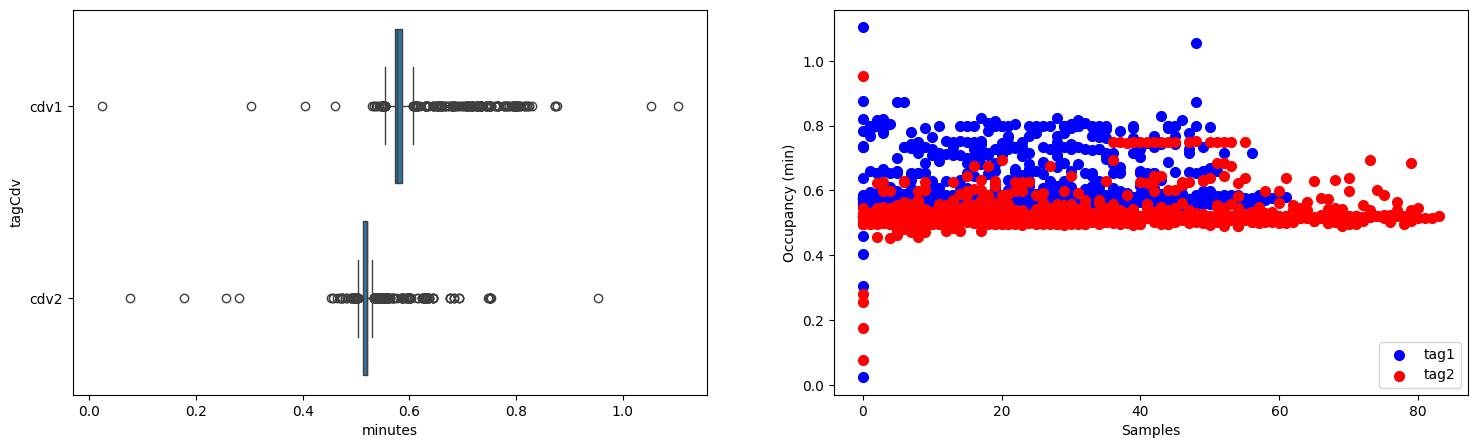

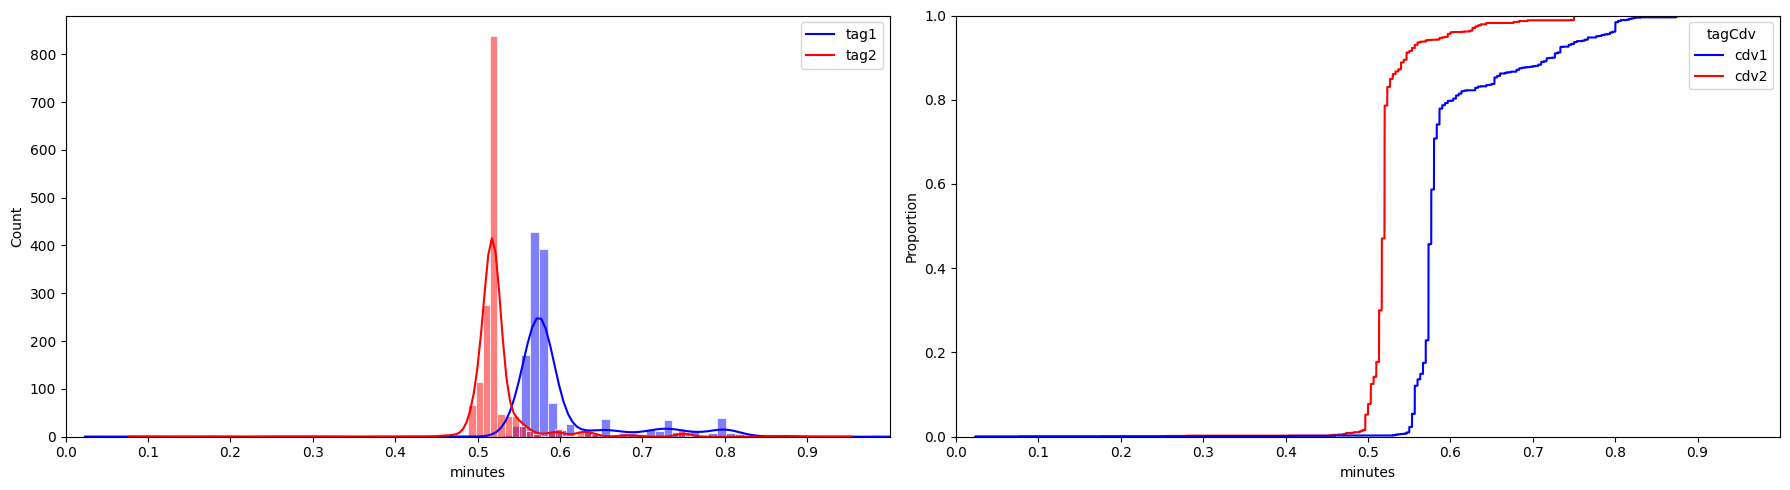

In [7]:
# plot boxplot

figura_tamaño = (18,5)

fig, axes = plt.subplots(1,2, figsize=figura_tamaño)
# _1 para tag1 , _2 para tag2
x1, x2 = data1.index, data2.index
y1 , y2 =data1['minutes'], data2['minutes']

# muestra boxplot para tag 1 y tag 2
sns.boxplot(data=result, x="minutes", y="tagCdv", ax=axes[0])

# grafica los datos 
axes[1].scatter(x1, y1, linewidth=2.0, color='blue')
axes[1].scatter(x2, y2, linewidth=2.0, color = 'red')
#ax.boxplot(y)

plt.xlabel('Samples') 
plt.ylabel('Occupancy (min)') 
plt.legend(["tag1", "tag2"], loc="lower right")
plt.show

#-----------------------------------------------------
# histograma para tags{1,2}

fig , axes= plt.subplots(1,2, figsize= figura_tamaño)
axes = axes.ravel()

sns.histplot(y1, bins=100, linewidth=0.5, edgecolor="white", color='blue', kde=True, ax=axes[0])
sns.histplot(y2, bins=100, linewidth=0.5, edgecolor="white", color='red', kde =True, ax=axes[0]) 
axes[0].legend(["tag1", "tag2"], loc="upper right")
axes[0].set_xlim(0, 1)
axes[0].set_xticks(np.arange(0, 1, step=0.1))

# distribución acumulativa
sns.ecdfplot(result, x='minutes', hue="tagCdv", palette=['blue', 'red'], ax=axes[1])
axes[1].set_xlim(0, 1)
axes[1].set_xticks(np.arange(0, 1, step=0.1))

fig.tight_layout()
plt.show()

## Diferentes técnicas para encontrar los outliers

detección de outliers usando 1.5*IQR

In [8]:
import numpy as np
# se carga solo datos del tag 1


def calculoCuantil(df,columna, ntag):

    # cuantil 0.75 y 0.25
    q75, q25 = np.quantile(df[columna],0.75), np.quantile(df[columna],0.25)

    # quantil interno
    iqr=q75-q25
    corte =1.5*iqr

    #niveles de corte 
    nivel_bajo, nivel_alto = q25-corte, q75+corte

    #almacena los datos en diferentes dataFrame
    df1=df[df['minutes']>nivel_alto]
    df2=df[df['minutes']<nivel_bajo]
    
    #se muestran los niveles min y max
    print(f'\ndataframe: {ntag}')
    print(f'valor min: {nivel_bajo}, valor max: {nivel_alto}')

    return [nivel_bajo, nivel_alto, df1, df2]




dataframe: tag1
valor min: 0.5534331395833334, valor max: 0.6068045895833332

dataframe: tag2
valor min: 0.5033699583333334, valor max: 0.5302520249999999


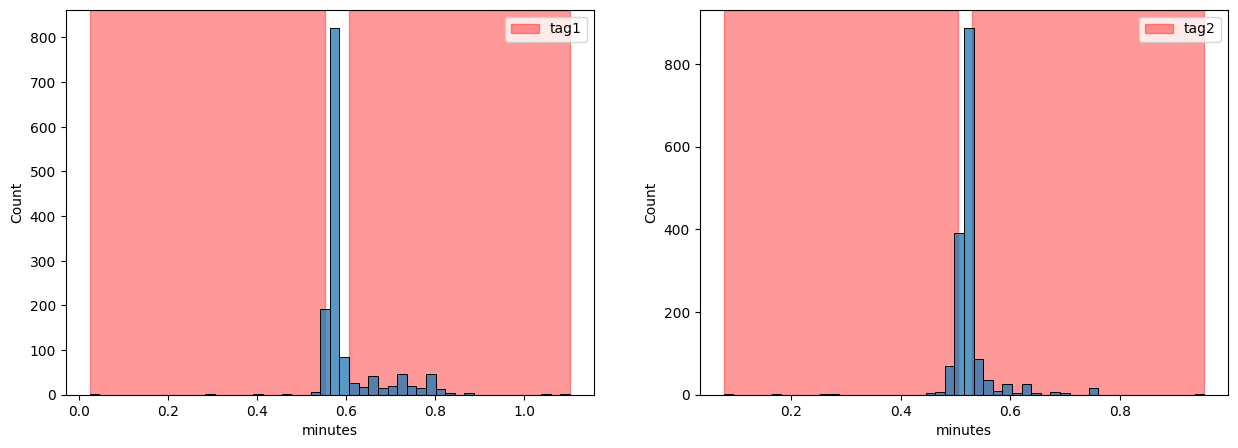

In [9]:
# lista de dataFrames a graficar
lista_datos = [data1, data2]
tags = ['tag1', 'tag2']


fig, axes = plt.subplots(1, 2, figsize=(15,5))

for ax, datos, xtag in zip(axes, lista_datos, tags):
    niveles_quantles = calculoCuantil(datos,'minutes',xtag)
    ax.axvspan(xmin = niveles_quantles[0],xmax= datos.minutes.min(),alpha=0.4, color='red')
    ax.axvspan(xmin = niveles_quantles[1],xmax= datos.minutes.max(),alpha=0.4, color='red')
    sns.histplot(datos.minutes, bins= 50, kde=False, ax=ax)
    ax.legend([xtag], loc="upper right")


dataframe: tag1
valor min: 0.5534331395833334, valor max: 0.6068045895833332

dataframe: tag2
valor min: 0.5033699583333334, valor max: 0.5302520249999999


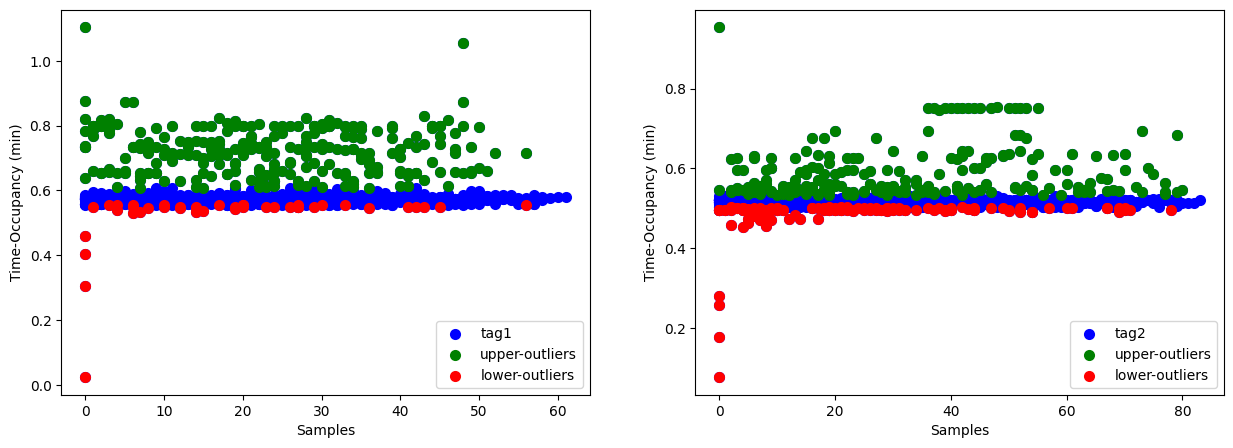

In [10]:
# lista de dataFrames a graficar
lista_datos = [data1, data2]
tags = ['tag1', 'tag2']
columna ='minutes'

# se configura los subplots
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# se ejecuta para cada dato de la lista de datos

for ax, datos, xtag in zip(axes, lista_datos, tags):

    quantiles = calculoCuantil(datos,columna,xtag)
    ax.scatter(datos.index, datos[columna], linewidth=2.0, color='blue')
    ax.scatter(quantiles[2].index , quantiles[2].minutes, linewidth=2.0, color='green')
    ax.scatter(quantiles[3].index, quantiles[3].minutes, linewidth=2.0, color='red')
    ax.set(xlabel='Samples', ylabel='Time-Occupancy (min)')
    ax.legend([xtag,'upper-outliers','lower-outliers'], loc="lower right")


Z -SCORE METODO

se asume que los datos siguen una distribución normal y que los outliers son los que se alejan de la media. Un criterio es que muestras mayor a 3 y menor -3 son considerados como outliers.
Se transforman los datos en relación a la media y desviación estándar y verificar como se destribuye entorno a la media =0 y estandar desviación =1. N(0,1)

$zscore(x) = \frac{(x - \mu)}{\sigma}$ , outliers: $|{zscore}>3|$

In [15]:
# Función para calcular Z-score

def calculo_zscore(datos_X, col,ntag):
    outliers=[]
    zscores = []
    level_corte = 3
    mean = np.mean(datos_X[col])
    std = np.std(datos_X[col])
    for x in datos_X[col]:
        zscore_x = (x-mean)/std
        zscores.append(zscore_x)
        #si es |x| >3 -> outliers
        if(np.abs(zscore_x) > level_corte):
           outliers.append(zscore_x)
        #se muestran los niveles min y max
    print(f'\ndataframe: {ntag}')
    print(f'N outlier: {len(outliers)}')
    return [outliers,zscores]


dataframe: tag1
N outlier: 17

dataframe: tag2
N outlier: 32


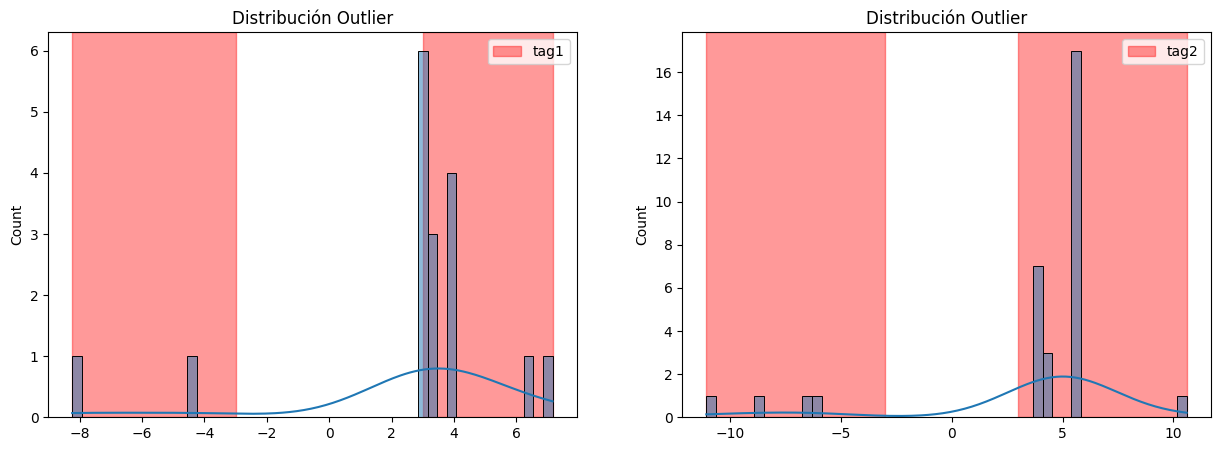

In [27]:
# lista de dataFrames a graficar
lista_datos = [data1, data2]
tags = ['tag1', 'tag2']


fig, axes = plt.subplots(1, 2, figsize=(15,5))

for ax, datos, xtag in zip(axes, lista_datos, tags):
    z_scores = calculo_zscore(datos,'minutes',xtag)
    ax.axvspan(xmin = 3 ,xmax= max(z_scores[1]),alpha=0.4, color='red')
    ax.axvspan(xmin = min(z_scores[1]) ,xmax= -3,alpha=0.4, color='red')
    sns.histplot(z_scores[0], bins= 50, kde=True, ax=ax)
    ax.legend([xtag], loc="upper right")
    ax.set_title('Distribución Outlier')
    

Algoritmo LOF
(LOF) es un algoritmo de detección de anomalia no supervisado donde se computa la desviación de densidad y sus vecinos.
El parámetro ``` n_neighbors ``` establece el número de puntos que se consideran para calcular la densidad local. Los valores outliers tendran menor densidad local de sus ```k - neighbors ``` . Por otra parte la  ```contamination ``` representa el % de outlier sobre los datos. Se eligió un valor inicial ```contamination =0.02 ```  

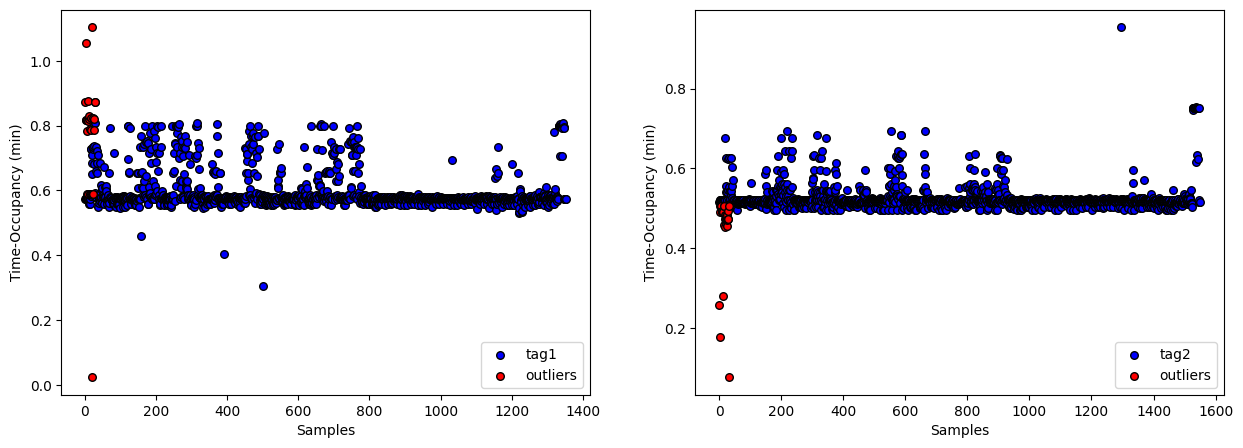

In [20]:
from sklearn.neighbors import LocalOutlierFactor

# lista de dataFrames a graficar
lista_datos = [data1, data2]
tags = ['tag1', 'tag2']
columna ='minutes'

# se configura los subplots
fig, axes = plt.subplots(1, 2, figsize=(15,5))


for ax, df, xtag in zip(axes, lista_datos, tags):

    clf = LocalOutlierFactor( n_neighbors=30, contamination= 0.02)
    X = df[['minutes']].values
    y_pred = clf.fit_predict(X)

    # clasificación de los valores

    in_mask = [True if l == 1 else False for l in y_pred]
    out_mask = [True if l == -1 else False for l in y_pred]

    index1 = [item for item in range(1, len(X[in_mask, 0])+1)]
    index2 = [item for item in range(1, len(X[out_mask, 0])+1)]

    # Graficar local outlier factor
    # azul en zona
    ax.scatter(index1, X[in_mask, 0], c = 'blue',
                    edgecolor = 'k', s = 30)
    # outliers en rojo
    ax.scatter(index2, X[out_mask, 0], c = 'red',
                    edgecolor = 'k', s = 30)
    ax.set(xlabel='Samples', ylabel='Time-Occupancy (min)')
    ax.legend([xtag,'outliers'], loc="lower right")

[CLF] Se inició en ```n_neighbors = 20 ``` y se fue modificando para obtener los mejores resultados analizando la proporción de outliers sobre la muestra. donde ```n_neighbors =30 ``` fue uno de los mejores resultados con ```contamination = 0.02 ``` .  

Isolation Forest : Aisla la observación dividiendose recursivamente en ramas. Las anomalías tienen caminos más cortos. El valor de anomaly score es usado para diferenciar puntos outliers de observaciones normales.  El parámetro ```contamination ``` se eligió de forma automatica y representa la proporción de outliers en el conjunto de set.

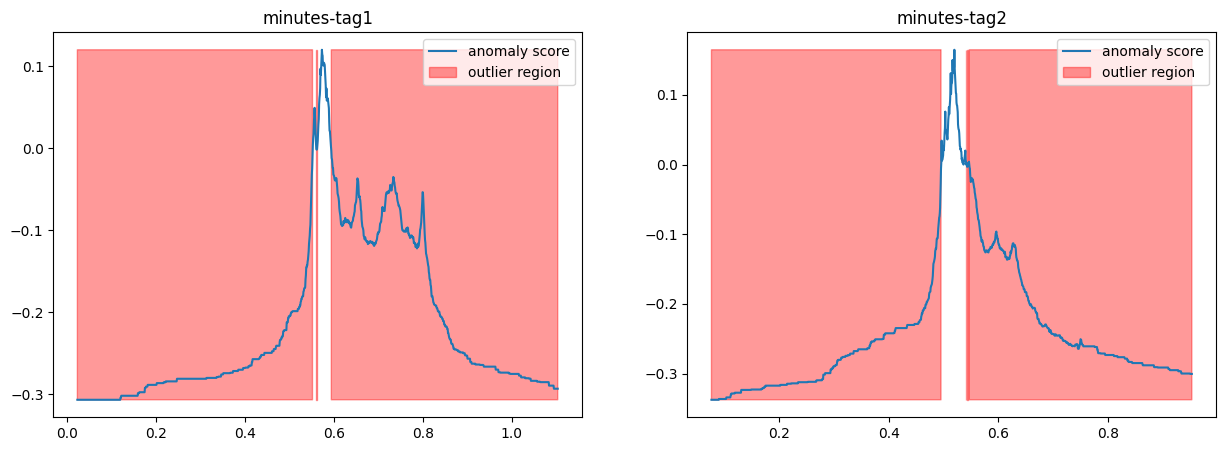

In [272]:
# Se importa la libreria
from sklearn.ensemble import IsolationForest

# lista de dataFrames a graficar
lista_datos = [data1, data2]
tags = ['tag1', 'tag2']
columna ='minutes'


#configuración de subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5), facecolor='w', edgecolor='k')


# se muestra la región de anomalía en rojo y el valor de anomalía en azul, 
# valor +: normal  valor -: anormal

for ax, df, xtag in zip(axes, lista_datos, tags):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[columna].values.reshape(-1,1))

    xx = np.linspace(df[columna].min(), df[columna].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    ax.plot(xx, anomaly_score, label='anomaly score')
    ax.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where=outlier==-1, color='r', alpha=.4, label='outlier region')
    ax.legend()
    ax.set_title(columna +'-' + xtag)

[Isolation Forest] el ```anomaly score ``` mientras más negativo es más anormal, valores positivos representan conjunto normal.

Se utiliza la librería Pyod: Libreria PyOD para outlier detección provee un amplio rango de algoritmos y técnicas para detectar anomalías, algunos de ellos métodos estadisticos, algoritmos de machine learning y deep learning.

Se eligió uno nuevo como es (HBO) Histogram-based outlier detection con un valor de ```contamination = 0.01``` que representa el % de outlier en el dataset.

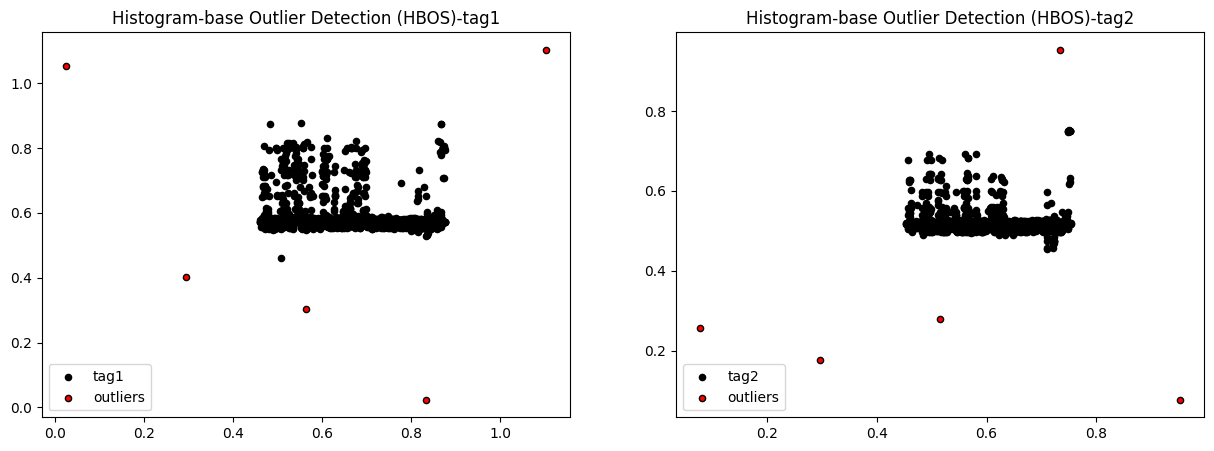

In [273]:
# Se importan los modelos desde pyod
import pyod
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn.preprocessing import MinMaxScaler

# se cargan los datos

lista_datos = [data1, data2]
tags = ['tag1', 'tag2']
columna ='minutes'

#configuración de subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5), facecolor='w', edgecolor='k')

for ax, dff, xtag in zip(axes, lista_datos, tags):

        # se escalan dentro de un rango de 0 a 1

        # scaler = MinMaxScaler(feature_range=(0, 1))
        # df[['minutes']] = scaler.fit_transform(df[['minutes']])

        # se cargan los datos a 
        X = dff['minutes'].values.reshape(-1,1)
        random_state = np.random.RandomState(42)

        # identifica el % para identificar los outlier. .1 es 10% es outlier
        outliers_fraction = 0.01

        # se cargan los diferentes modelos de clasificación 
        classifiers = {
                # 'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
                # 'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
                'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction)
                # 'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
                # 'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
                # 'Average KNN': KNN(method='mean',contamination=outliers_fraction)
        }

        for i, (clf_name, clf) in enumerate(classifiers.items()):
                clf.fit(X)

                # predice el score de anomalía
                scores_pred = clf.decision_function(X) * -1
                        
                # clasifica el dataset según el clasificacdor seleccinado como: inlier o outlier, 1: outlier, 0:inlier
                y_pred = clf.predict(X)

                #calculo los elemento inlier
                n_inliers = len(y_pred) - np.count_nonzero(y_pred)
                
                # calculo de los elementos outliers
                n_outliers = np.count_nonzero(y_pred == 1)
                
                # agrega una columna de clasificacion outlier
                # dff.loc[:,'outlier'] = pd.Series(y_pred, index=dff.index)
                dff = dff.assign(outlier=y_pred)

                # # IX1 - inlier feature 1,  IX2 - inlier feature 2
                IX1 =  dff[dff.outlier == 0].loc[:,'minutes'].values.reshape(-1,1)
                # # OX1 - outlier feature 1
                OX1 =  dff[dff.outlier == 1].loc[:,'minutes'].values.reshape(-1,1)
                
                #print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
                        
                # threshold value to consider a datapoint inlier or outlier
                #threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
                        
                # mostrando inlier y outliers
                
                xx1 = np.linspace(IX1.min(), IX1.max(), len(IX1)).reshape(-1,1)
                xx2 = np.linspace(OX1.min(), OX1.max(), len(OX1)).reshape(-1,1)

                ax.scatter(xx1, IX1, c='black',s=20, edgecolor='k')
                ax.scatter(xx2, OX1, c='red',s=20, edgecolor='k')
                ax.legend([xtag,'outliers'], loc="lower left")
                ax.set_title(clf_name +'-' + xtag)

### Conclusiones

_________________

* Tag1 y Tag2 tienen distribuciones parecidas pero con valores de media ligeramente diferentes.
+ Existe un overlap entre las señales que se requiere un criterio para discriminar a qué tipo de metro pertenece(tamaño).
+ Se probaron diferentes técnicas para detectar y validar outlier y zonas de anomalías
    + No todos los algoritmos usados obtenemos los mismos resultados
    + Se debe tener en cuento algunos parámetros los cuales influyen directamente en los resultados obtenidos, como el es el porcentaje de outlier para el nivel de decisión del algoritmo.
+ Se considera como objetivo la zona inferior, $< \mu_{x}$ debido a que se necesita detectar los Falsos Negativos (FN) o error tipo 2.
    - Se eliminarán los outliers superior eligiendo el criterio de 1.5*IQR
    - Se ajustara el criterio de decisión.
    - Se verificará la sensibilidad para descriminar ambas señales.